# Objective: To build a CNN based model which can accurately detect melanoma.
* Melanoma is a type of cancer that can be deadly if not detected early.
* It accounts for 75% of skin cancer deaths.
* A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. 
* It can also be life saving in poor countires where avaibility of medical experts is low as well as healthcare cost is high.

## INDEX

* [Data Sourcing](#Data-Sourcing)
* [Basic EDA](#Basic-EDA)
* [Model Creation](#Model-Creation)
    1. [Model 1 : simple CNN model](#Model-1-:-simple-CNN-model)
        * [Observation from model 1](#Observation-from-model-1)
    2. [Model 2 : Building more complex model](#Model-2-:-Building-more-complex-model)
        * [Observation from model 2](#Observation-from-model-2)
    3. [Model 3 : Implementing augmentation strategy and regularization](#Model-3-:-Model-creation-using-data-augmentaion-and-dropouts)
        * [Observation from model 3](#Observation-from-model-3)
    4. [Model 4 : Building a model after handling class imbalance](#Model-4-:-Building-a-model-after-handling-class-imabalnce)
        * [Observation from model 4](#Observation-from-model-4)
* [Evalution on unseen/Test data](#Evalution-on-unseen/Test-data)
* [Prediction on Test samples](#Prediction-on-Test-samples)
* [Conclusion](#Conclusion)

In [1]:
# Importing liabraries for data processing and visualization:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import math
import os
import PIL
import seaborn as sns
from zipfile import ZipFile

# Importing Deep learning liabraries:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Data Sourcing
    * The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). 
    * The dataset contains 9 sub-directories in each train and test subdirectories. 
    * The 9 sub-directories contains the images of 9 skin cancer types respectively.
- The data set contains the following 9 skin diseases:
 - Actinic keratosis
 - Basal cell carcinoma
 - Dermatofibroma
 - Melanoma
 - Nevus
 - Pigmented benign keratosis
 - Seborrheic keratosis
 - Squamous cell carcinoma
 - Vascular lesion

We can use google colab which offers free gpu resources with certain limitations for deep learning. But since our dataset is not that huge and the fact that i have local nvidia 20 series graphics card with sufficient cuda cores and memory resources, i will make use of that.
NOTE: Kindly use path as per your data directory.

In [2]:
# # If you are using google colab and using the data by mounting the google drive, use the following :

# from google.colab import drive
# drive.mount('/content/gdrive')

# # Unzips 'CNN_assignment.zip' file and store the content at path "/content/gdrive/MyDrive/Dataset/" :
# !unzip -q "/content/gdrive/MyDrive/Dataset/CNN_assignment.zip" -d "/content/gdrive/MyDrive/Dataset/"

# # Providing the train and test data path. 
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
# # If you are training locally and using locally stored dataset, use the following :

# specifying the zip file name:
file_name = r"C:\Users\ADMIN\Downloads\CNN_assignment.zip"
  
# opening the zip file in READ mode:
with ZipFile(file_name, 'r') as zip_ref:
    # extracting all the files to path "C:\Users\ADMIN\Downloads\CNN_assignment":
    print('Extracting all the files now...')
    zip_ref.extractall(r"C:\Users\ADMIN\Downloads\CNN_assignment")
    print('Done!')

Extracting all the files now...
Done!


In [4]:
# # Providing the train and test data path:
data_dir_train = pathlib.Path(r"C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r'C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [5]:
# # high level overview of dataset records:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'number of images available in train set are : {image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'number of images available in test set are : {image_count_test}')

number of images available in train set are : 2239
number of images available in test set are : 118


#### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Creating and formating dataset for training and testing purpose:
    * For generating train,validation and test set from image files in a directory, we will take help of image_dataset_from_directory utility of tensorflow keras preprocessing.
    * It may happen that dataset has records of varying dimenssions(i.e. width*height). We will reshape the image dimenssions to 180*180 since we need to define dimenssions of input layer as a fixed parameter.
- BATCH SIZE: Hyper parameter
    - In Stochastic Gradient Descent, we we update the parameters after every single observation. This is computationally very demanding for large datasets.
    - On the other hand, if we use batch Gradient Descent, it takes entire dataset into consideration for single updation. Which becomes an issue for large data set because of memory contraints.
    - To overcome this, we divide training data into smaller multiple batches also called as mini-batches.Here we compute the average gradient for a batch, and update the weights based on that gradient. For example, if we have 3200 data points, we will have to make weight and biases update 3200 times (i.e. for every data point) in Stochastic Gradient Descent. But in case of mini batch gradient descent we will have to make weight and biases update only 100 times if we take mini-batch of size 32.
        - mini-batch gradient descent is a descent compromise between Stochastic and batch Gradient Descent.It provides additional advantage of robust convergence by allowing you reach the global minima (instead of being stuck at a local minima).
        - one disadvantage is that size of mini-batch is a hyper parameter and requires manual tuning.
        - mini-batch size of 32 is commonly used.

    * Our original training set has 2239 records which belong to 9 classes.
    * We will divide this original training set further into two subsets in 80:20 ratio:
        - Training subset : for actual training.
        - Validation subset : for validating results.

In [6]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = r"C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"

In [7]:
# Generating train dataset:
# Since task is multiclass image classification, our target is categorical. 
# Hence we will encode labels as a categorical vector.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory = data_dir,
  labels='inferred',                              # Labels are generated from the directory structure
  label_mode='categorical',                       # labels are encoded as a categorical vector
  validation_split=0.2,                           # 80% of the images for training
  subset="training",                              # Generating training subset
  seed=123,                                       # To reproduce the same randomness
  image_size=(img_height, img_width),             # Resizing images to 180*180
  batch_size=batch_size)                          # Batch size of 32

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Generating validation dataset:
# Since task is multiclass image classification, our target is categorical. 
# Hence we will encode labels as a categorical vector.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory = data_dir,
  labels='inferred',                            # Labels are generated from the directory structure
  label_mode='categorical',                     # labels are encoded as a categorical vector
  validation_split=0.2,                         # 20% for validating
  subset="validation",                          # Generating validation subset
  seed=123,                                     # To reproduce the same randomness
  image_size=(img_height, img_width),           # Resizing images to 180*180
  batch_size=batch_size)                        # Batch size of 32

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and storing them in a list:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Basic EDA

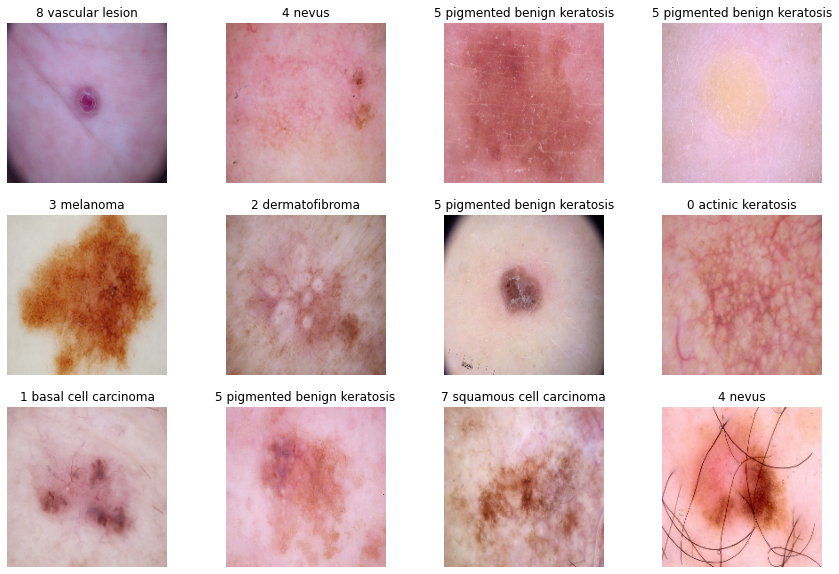

In [10]:
# visualizing random training samples:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = tf.argmax(labels[i]).numpy()
    plt.title(str(label)+' '+class_names[label])
    plt.axis("off")

In [11]:
# visualizing dimenssions of a mini-batch
for mini_batch,batch_labels in train_ds.take(1):
  print(mini_batch.shape)
  print(batch_labels.shape)
  break

(32, 180, 180, 3)
(32, 9)


From Above output we can see that:
- The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. 
- This is a batch of 32 images of shape `180x180x3` (the last dimension refers to number of channels i.e. color channels RGB).
- The `label_batch` is a tensor of the shape `(32,9)`, these are corresponding labels to the 32 images.

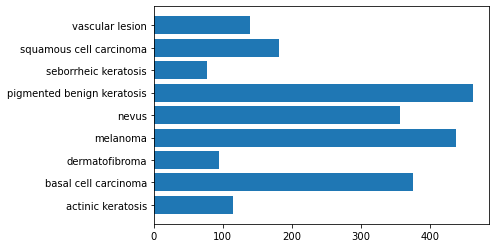

In [12]:
# Class distribution in entire training set:
class_dict = {}

for name in class_names:
    class_dict[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_label = list(class_dict.keys())
count = list(class_dict.values())

plt.barh(range(len(class_dict)), count, tick_label=class_label)
plt.show()

#### Some configurations to improve runtime :
`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

Cache will produce exactly the same elements during each iteration through the dataset. Thus to randomize the iteration order, we will call `shuffle()` after calling cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
`buffer_size` represents the maximum number of elements that will be buffered when prefetching. If the value `AUTOTUNE` is used, then the buffer size is dynamically tuned.

In [13]:
# Commands to improve computational and runtime efficiency:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation
- Creating a custom CNN model for multiclass classification.
- Data preprocessing:
    - normalizing pixel values : 
       - Since `our dataset consists of natural images` and value of each pixel is represented using 8 bits i.e. ranging from 0-255, computations will be more expensive as we will go deeper into networks and will require more memory (e.g. consider computing and storing 255^7). `Thus normalizing pixel values becomes crucial` in order to improve learning.
       - Additionally, If a Feature in the Dataset is big in scale compared to others then this big scaled feature may become dominating and will introduce bias. e.g. there is a large contrast in an image. Then output of NN will ne inaccurate. `Thus normalizing pixel values becomes crucial` in order to improve learning.

### Model 1 : simple CNN model
- For starters, we will build very `simple CNN model` to get basic idea.
- Since we are building a plain stack of layers where each layer has exactly one input tensor and one output tensor, `Sequential` model is appropriate for our task. Sequential() groups a linear stack of layers into a tf.keras.Model.
- We will provide normalizing pixel values between (0,1) as input to our sequential model using `Rescaling` layer.
- For spatial convolution over images i.e. `to extract features` we will use 2D convolution layers.
    - `filters` is an integer value which represents the number of output filters in the convolution.
    - `kernel_size` represents height and width of the 2D convolution filter.
    - `padding` parameter is used to provide padding statergy. when its value is provided as "same" then it results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
    - `For adding non-linearity`, we use activation function. We have decided to use `relu`i.e. Rectified Linear Unit function. 
        - Defination: f(x) = max(0,x)
- For Downsampling the extracted features along its spatial dimensions (height and width) i.e., to reduce the dimensions of the feature maps we will do `pooling`. It basically `summarises the features` present in a region of the feature map making them `invariant to local transformations` which ultimately result in more generalized model. More specifically, we will use `MaxPooling` statergy by taking the maximum value over an input window for each channel of the input.
    - `pool_size` is used to pass window size over which the maximum is taken. In our case we have decided to choose pooling window of (2,2)
- Before providing the output of final `Convolutional unit` to `dense` (i.e. fully connected layers) we need to flatten it out since output of `Convolutional unit` will be a tensor. It basically unrolls the tensor. For this we will take help of flatten layer.
- Output of flatten layer is then provided to Dense i.e. fully connected layers
    - `Units` parameter is used to define dimensions of the output space.
    - For hidden dense layer we have decided to use `relu` as activation function to introduce non-linearity.
    - Since our main objective is multiclass image classification, for output layer i.e. final dense layer we will use `softmax` as a activation function which is basically a generalization of the logistic function for multiple classes. Also, since we have to classify among 9 classes, `output layer i.e. final dense layer units will be equal to number of classes which is equal to 9`.

In [14]:
# Building MODEL 1
total_classes = 9

model1 = Sequential()
model1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))) #normalizing pixel values between (0,1)
model1.add(layers.Conv2D(filters=4, kernel_size=(3, 3),padding='same',activation="relu"))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Conv2D(filters=4, kernel_size=(3, 3),padding='same', activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Conv2D(filters=4, kernel_size=(3, 3),padding='same', activation="relu"))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=8, activation='relu'))
model1.add(layers.Dense(units=total_classes, activation='softmax'))

Model Compilation:
- optimizer: `We have selected adam` as an optimizer.
    - adam is gradient descent optimization method.
    - adam uses both momentum and Adagrad but with the exponentially weighted average with the corresponding bias corrections.
- loss function : Since our target variable is categorical `we will use categorical_crossentropy` as a loss function.
- metrics : `We have chose to use accuracy` as a evalution metric since our task is to accurately detect 9 classes present in the dataset. 
    - We acknowledge that, incase of high class imbalance, `accuracy metric may give misguiding results`. Thus we must take care of class proportions.
    - If we want to give a priority of detecting a particular class over the other e.g., detecting melanoma over harmless moles we can use weighted loss function and `auc` or `recall` as a metric.

In [15]:
## Compiling the model:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
#  summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 4)         148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 4)         148       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 4)         0

In [17]:
# Training the model 
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 6s 27ms/step - loss: 2.0938 - accuracy: 0.1920 - val_loss: 2.0504 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 1s 12ms/step - loss: 2.0394 - accuracy: 0.1931 - val_loss: 2.0256 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 1s 12ms/step - loss: 2.0208 - accuracy: 0.2037 - val_loss: 2.0381 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 1s 12ms/step - loss: 2.0125 - accuracy: 0.2148 - val_loss: 2.0144 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 1s 12ms/step - loss: 1.9872 - accuracy: 0.2232 - val_loss: 2.1493 - val_accuracy: 0.2215
Epoch 6/20
56/56 [==============================] - 1s 12ms/step - loss: 1.9245 - accuracy: 0.2773 - val_loss: 1.8970 - val_accuracy: 0.3468
Epoch 7/20
56/56 [==============================] - 1s 12ms/step - loss: 1.8575 - accuracy: 0.3086 - val_loss: 1.8247 - val_accuracy: 0.3647
Epoch 8/20
56

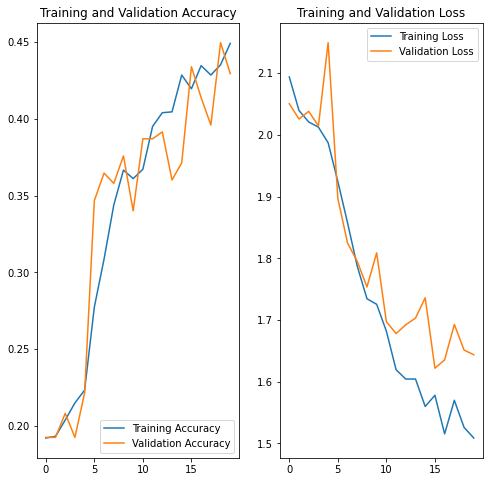

In [18]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation from model 1
- Observation : `Our model seems to underfit` as it performs poorly on training data itself.
- Reason : Model is too simple.
- solution : We can try adding more filters in convolution layers as well as increase units in dense layers i.e. make model more complex.

### Model 2 : Building more complex model

In [19]:
# Building MODEL 2
model2 = Sequential()
model2.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model2.add(layers.Conv2D(filters=16, kernel_size=(3, 3),padding='same',activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3),padding='same', activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(total_classes, activation='softmax'))

In [20]:
## Compiling the model:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# summary of all layers
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [22]:
### Training the model
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 23ms/step - loss: 2.0696 - accuracy: 0.1886 - val_loss: 2.0659 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 1.9821 - accuracy: 0.2266 - val_loss: 1.9494 - val_accuracy: 0.2282
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.7318 - accuracy: 0.3750 - val_loss: 1.6650 - val_accuracy: 0.3781
Epoch 4/20
56/56 [==============================] - 1s 18ms/step - loss: 1.6614 - accuracy: 0.3834 - val_loss: 1.6426 - val_accuracy: 0.4161
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 1.6207 - accuracy: 0.4169 - val_loss: 1.5724 - val_accuracy: 0.4362
Epoch 6/20
56/56 [==============================] - 1s 18ms/step - loss: 1.4794 - accuracy: 0.4916 - val_loss: 1.4655 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 18ms/step - loss: 1.4453 - accuracy: 0.4967 - val_loss: 1.4616 - val_accuracy: 0.5034
Epoch 8/20
56

### Observation from model 2
- Observation : Now our training accuracy has improved. But validation accuracy has not improved by much.Our Model performs very well on training data but fails to do same on validation data which indicates `our model is now overfitting`.
- Reason : Model is also learning noise present in the data instaed of just capturing desired pattern/feature of underlying data. In other word model fails to generalize because it is too complex. another possible reason for overfitting is that we have very less training data and NN require large amount of data for training.
- Solution : We can resolve this using data augmentation statergy.
We also need to have regularization to generalize the model which can be implemented using dropouts

#### Data augumentation strategy: 
- we will use random flip and random rotation for data augmentation.
- We will not use random zoom as random zoom may exclude our region of interest (e.g a mole) causing loss of crucial information


In [23]:
# data augumentation using preprocessing module of tensorflow keras:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1)
  ]
)

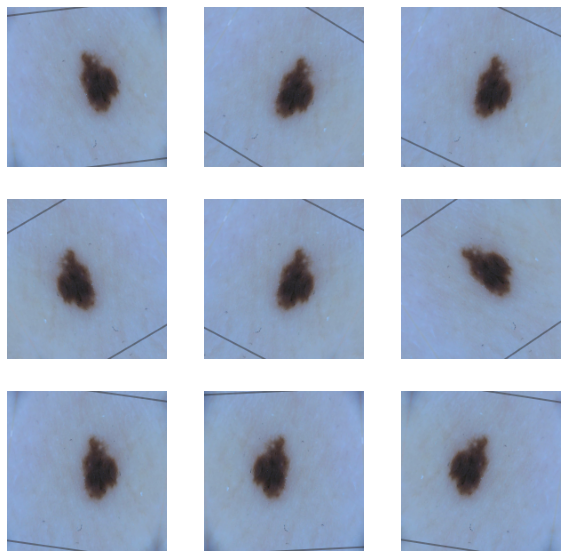

In [24]:
# visualizing how our augmentation strategy works for one instance of training image:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[2].numpy().astype("uint8"))
    plt.axis("off")

### Model 3 : Model creation using data augmentaion and dropouts
- As we know, not every augmentatiuon statergy can be applied to data. In other words we must carefully choose augmentatiuon statergy depending on problem statement.
- `RandomRotation` : Randomly rotates an image.
- `RandomFlip`  : Randomly flips an image horizontally and vertically.
- `We have choose not to use zooming or croping as it may lose desired information such as skin patch of interest`.
- We are also using `dropouts` to generalize the model i.e., to control overfitting.

In [25]:
# Building Model 3
model3 = Sequential()
model3.add(layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)))
model3.add(layers.experimental.preprocessing.RandomRotation(0.1))
model3.add(layers.experimental.preprocessing.Rescaling(1./255))
model3.add(layers.Conv2D(filters=16, kernel_size=(3, 3),padding='same',activation="relu"))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=32, kernel_size=(3, 3),padding='same', activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation="relu"))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Dropout(0.3))
model3.add(layers.Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Dropout(0.4))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(total_classes, activation='softmax'))

In [26]:
## Compiling the model:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
# summary of all layers
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 32)       

In [28]:
### Training the model
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 2s 23ms/step - loss: 2.0050 - accuracy: 0.2467 - val_loss: 1.8887 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7307 - accuracy: 0.3655 - val_loss: 1.6294 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7001 - accuracy: 0.3728 - val_loss: 1.6470 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5997 - accuracy: 0.4325 - val_loss: 1.6388 - val_accuracy: 0.3870
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5685 - accuracy: 0.4347 - val_loss: 1.5439 - val_accuracy: 0.4362
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5226 - accuracy: 0.4537 - val_loss: 1.5151 - val_accuracy: 0.4564
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4738 - accuracy: 0.4766 - val_loss: 1.5361 - val_accuracy: 0.4653
Epoch 8/20
56

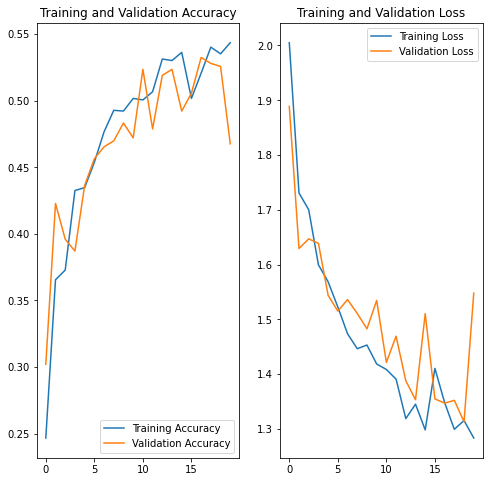

In [29]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation from model 3
- Observation : Now after implementation of drop outs and augmentation, we obseve that our train and validation accuracy is far better than simpler model 1. 
Also, this `Model is not overfitting` which was the case for model 2.
Althogh, train and validation accuracy has improved as compared to model 1, `There is still large room for improvement`. 
- Reason : Under performance of a model may be due to the presence of class imbalance in our dataset.
- Solution : `eliminating class imbalance with the help of Data Augmentaion`.

#### Distribution of classes in the training dataset:
- Class imbalance: We say we have class imbalance when one class is dominantly present as compared to others in training dataset. e.g., In fraud detection, data present for fraud cases is very less than genuine transactions.
- If we dont deal with class imbalance then predictions made by NN will not be accurate as NN will be more biased towards dominating class.

In [30]:
# We will create df to visualize class imbalance.

# Getting path of each image and storing them in list path_list
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
# Getting class label of each image and storing them in list lesion_list
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
total_training_records = len(path_list)

In [31]:
# Creating df which maps each image (path of each image to be more precise) with its class label
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
print(f'shape of original_df is {original_df.shape}')
original_df.sample(5)

shape of original_df is (2239, 2)


,Path,Label
766,C:\Users\ADMIN\Downloads\CNN_assignment\Skin c...,melanoma
234,C:\Users\ADMIN\Downloads\CNN_assignment\Skin c...,basal cell carcinoma
33,C:\Users\ADMIN\Downloads\CNN_assignment\Skin c...,actinic keratosis
114,C:\Users\ADMIN\Downloads\CNN_assignment\Skin c...,basal cell carcinoma
1490,C:\Users\ADMIN\Downloads\CNN_assignment\Skin c...,pigmented benign keratosis


In [32]:
class_percent = original_df.Label.value_counts().to_dict()

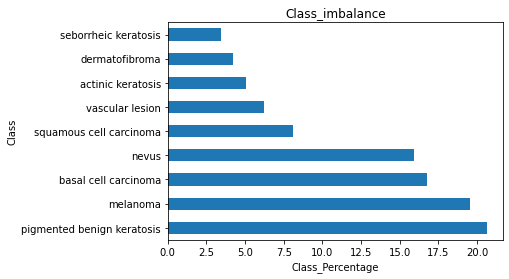

In [33]:
# Visualizing class imbalance:
round((original_df.Label.value_counts()/total_training_records*100),2).plot(kind = 'barh')
plt.xlabel('Class_Percentage')
plt.ylabel('Class')
plt.title('Class_imbalance')
plt.show()

Observation:
- `seborrheic keratosis class has least number of samples` corresponding to roughly, only 3.4% of training data.
- `pigmented benign keratosis class is dominating` the training data occupying roughly 20.6% of training data.

#### Handling class imbalance:
We will take care of class imbalance with the help of  `Augmentor` package to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:
1. We Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Then we define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Lastly, we execute these operations by calling the `Pipeline’s` `sample()` method.

In [34]:
# Installing Augmentor package :
!pip install Augmentor

In [35]:
## adding 500 augmented images to each class :
# path_to_training_dataset= str(data_dir_train)

# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + '\\'+ i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.flip_random(.7)
#     p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Adding 500 augmented images to each class reduces class imbalance upto certain extent but not completely. For better handling of class imbalance we have taken following aproach of augmenting images to a class depending upon proportion of that class. 

In [36]:
# Adding augmented images to each class w.r.t. proportion of that class:

path_to_training_dataset=r"C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+ '\\' + i)
    p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
    if i == 'seborrheic keratosis':
        p.sample(800-class_percent['seborrheic keratosis']) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    elif i == 'dermatofibroma':
        p.sample(800-class_percent['dermatofibroma'])
    elif i == 'actinic keratosis':
        p.sample(800-class_percent['actinic keratosis'])
    elif i == 'vascular lesion':
        p.sample(800-class_percent['vascular lesion'])
    elif i == 'squamous cell carcinoma':
        p.sample(800-class_percent['squamous cell carcinoma'])
    elif i == 'nevus':
        p.sample(800-class_percent['nevus'])
    elif i == 'basal cell carcinoma':
        p.sample(800-class_percent['basal cell carcinoma'])
    elif i == 'melanoma':
        p.sample(800-class_percent['melanoma'])
    elif i == 'pigmented benign keratosis':
        p.sample(800-class_percent['pigmented benign keratosis'])

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x195C347A8E0>:   1%| | 4/686 [00:00<00:12, 53.29 Samples/s]

Initialised with 114 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x195C6AFAF40>: 100%|█| 686/686 [00:01<00:
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x195C3446460>:   4%| | 19/424 [00:00<00:0

Initialised with 376 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x195C6A6C910>: 100%|█| 424/424 [00:01<00:
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x195C6A71F40>:   2%| | 15/705 [00:00<00:09, 69.24 Samples/s

Initialised with 95 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x195C6A0E9A0>: 100%|█| 705/705 [00:01<00:00, 356.91 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x195C6E7E220>:   0%| | 1/362 [00:00<00:3

Initialised with 438 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x195C6E9ED90>: 100%|█| 362/362 [00:05<00:00, 68.73 Samples
Executing Pipeline:   0%|                                                                | 0/443 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x195C6A0CB80>: 100%|█| 443/443 [00:05<00:00, 76.04 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x195C6A92C70>:   6%| | 19/338 [00:00<00:0

Initialised with 462 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1948B2C1CA0>: 100%|█| 338/338 [00:00<00:00, 366.50 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x195C3432C70>:   0%| | 2/723 [00:00<00:5

Initialised with 77 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x195C6ACE760>: 100%|█| 723/723 [00:04<00:00, 175.59 Sample
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x195C6A71D00>:   0%|         | 0/619 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1948B2CE3D0>: 100%|█| 619/619 [00:01<00:
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x195C6A12AF0>:   2%| | 15/661 [00:00<00:1

Initialised with 139 image(s) found.
Output directory set to C:\Users\ADMIN\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x195C6E70730>: 100%|█| 661/661 [00:01<00:00, 365.48 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
# total count of augmented images.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(f'total count of augmented images is {image_count_train}')

total count of augmented images is 4961


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
# Getting path of each augmented image and storing them in list path_list_new
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [39]:
# Getting class label of each augmented image and storing them in list lesion_list_new
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [40]:
# Creating df which maps new augmented image (path of each image to be more precise) with its class label
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [41]:
# Appending df containg information of augmented images to original df to merge them:
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

seborrheic keratosis          800
basal cell carcinoma          800
vascular lesion               800
melanoma                      800
actinic keratosis             800
dermatofibroma                800
squamous cell carcinoma       800
nevus                         800
pigmented benign keratosis    800
Name: Label, dtype: int64

In [43]:
# Checking class percentage:
round((new_df.Label.value_counts()/len(new_df.index)*100),2)

seborrheic keratosis          11.11
basal cell carcinoma          11.11
vascular lesion               11.11
melanoma                      11.11
actinic keratosis             11.11
dermatofibroma                11.11
squamous cell carcinoma       11.11
nevus                         11.11
pigmented benign keratosis    11.11
Name: Label, dtype: float64

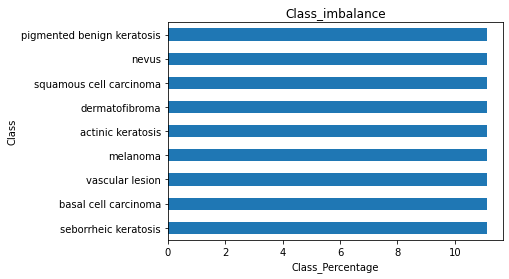

In [44]:
round((new_df.Label.value_counts()/len(new_df.index)*100),2).plot(kind = 'barh')
plt.xlabel('Class_Percentage')
plt.ylabel('Class')
plt.title('Class_imbalance')
plt.show()

#### Creating a training dataset after Augmentation:

In [45]:
batch_size = 32
img_height = 180
img_width = 180

In [46]:
# Creating a train sunset
data_dir_train=str(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred', 
  label_mode='categorical',
  validation_split=0.2,
  seed=123,
  subset ="training", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7200 files belonging to 9 classes.
Using 5760 files for training.


In [47]:
# Creating a validation subset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred', 
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = "validation", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7200 files belonging to 9 classes.
Using 1440 files for validation.


### Model 4 : Building a model after handling class imabalnce

In [48]:
# Building Model 4
model4 = Sequential()
model4.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model4.add(layers.Conv2D(filters=16, kernel_size=(3, 3),padding='same',activation="relu"))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Conv2D(filters=32, kernel_size=(3, 3),padding='same', activation='relu'))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation="relu"))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Dropout(0.4))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu'))
model4.add(layers.Dense(total_classes, activation='softmax'))

In [49]:
# summary of all layers
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 22, 22, 64)       

In [50]:
# Compiling the model
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
# Training the model
epochs = 30
history = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
180/180 [==============================] - 8s 44ms/step - loss: 2.1871 - accuracy: 0.1208 - val_loss: 1.9476 - val_accuracy: 0.2396
Epoch 2/30
180/180 [==============================] - 7s 36ms/step - loss: 1.6912 - accuracy: 0.3340 - val_loss: 1.5201 - val_accuracy: 0.3826
Epoch 3/30
180/180 [==============================] - 7s 35ms/step - loss: 1.4350 - accuracy: 0.4406 - val_loss: 1.3824 - val_accuracy: 0.4583
Epoch 4/30
180/180 [==============================] - 7s 35ms/step - loss: 1.3453 - accuracy: 0.4802 - val_loss: 1.2202 - val_accuracy: 0.5431
Epoch 5/30
180/180 [==============================] - 7s 35ms/step - loss: 1.2520 - accuracy: 0.5196 - val_loss: 1.1886 - val_accuracy: 0.5424
Epoch 6/30
180/180 [==============================] - 7s 35ms/step - loss: 1.1683 - accuracy: 0.5590 - val_loss: 1.1230 - val_accuracy: 0.5556
Epoch 7/30
180/180 [==============================] - 7s 35ms/step - loss: 1.0500 - accuracy: 0.6080 - val_loss: 0.9841 - val_accuracy: 0.6347

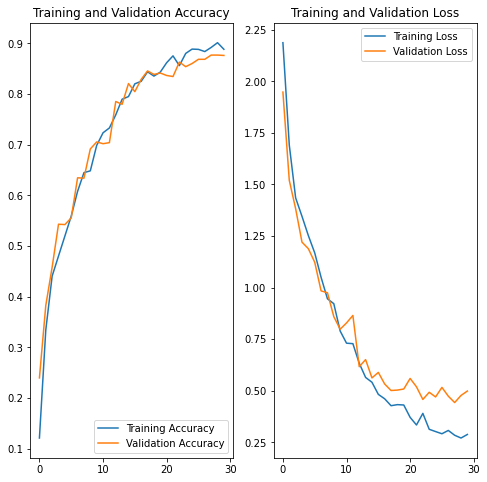

In [52]:
# Visualizing the model results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation from model 4
Observation : Now after handling class imbalance, our model is no more overfitting. It is performing well as we are getting pretty good train and validation scores.

### Evalution on unseen/Test data

In [53]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                             data_dir_test, 
                             labels='inferred',  # Labels are generated from the directory structure
                             label_mode='categorical',  # labels are encoded as a categorical vector
                             image_size=(img_height, img_width), 
                             batch_size=batch_size)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


In [54]:
loss, accuracy = model4.evaluate(test_dataset)

4/4 [==============================] - 1s 67ms/step - loss: 4.1428 - accuracy: 0.4407


### Prediction on Test samples

In [55]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
pred_batch = model4.predict_on_batch(image_batch)
class_predictions = tf.where(
        tf.equal(tf.reduce_max(pred_batch, axis=1, keepdims=True), pred_batch), 
        tf.constant(1, shape=pred_batch.shape), 
        tf.constant(0, shape=pred_batch.shape)
    )

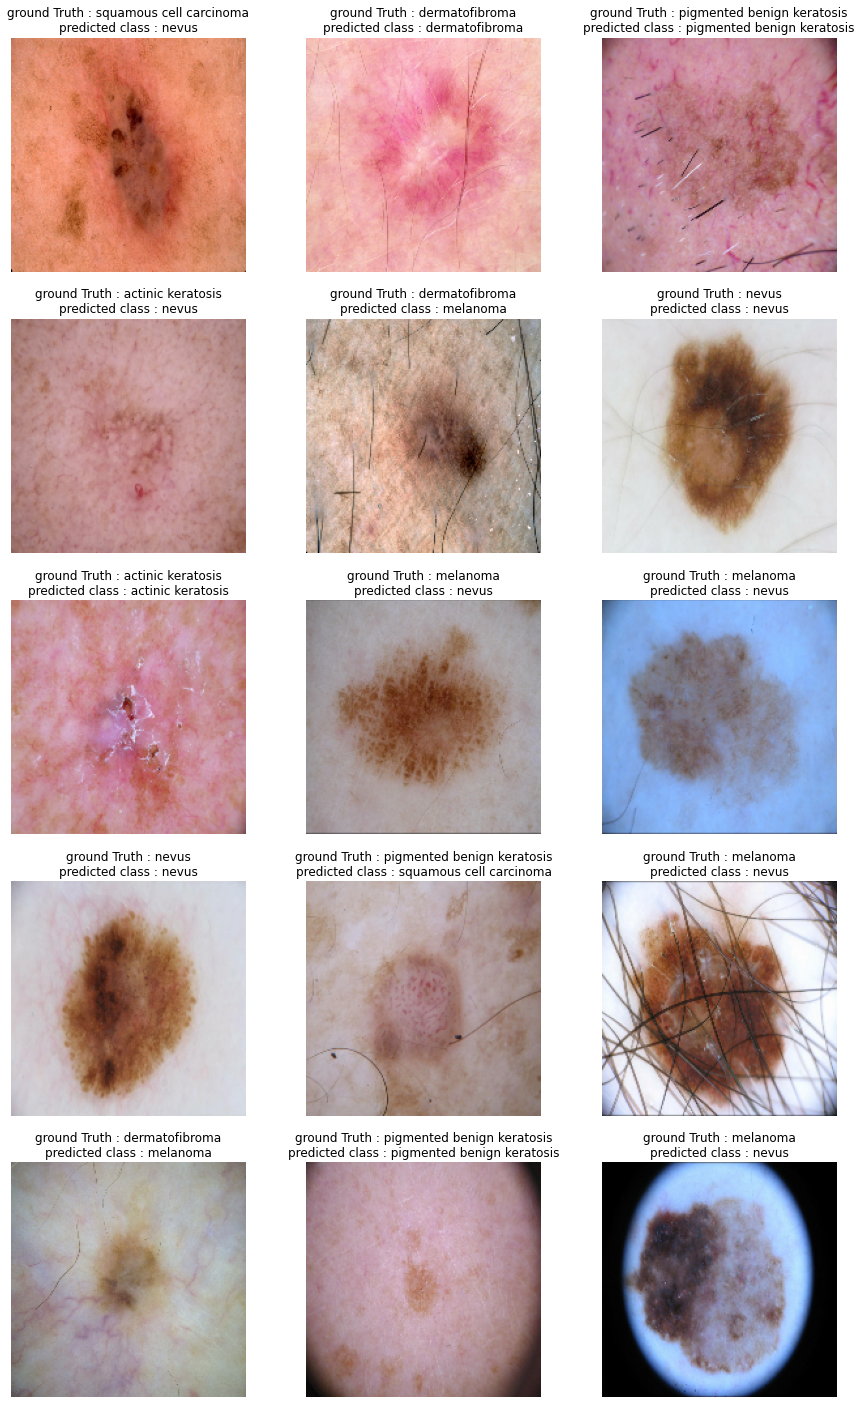

In [56]:
plt.figure(figsize=(15, 25))
for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(image_batch[i].astype('uint8'))
        label = tf.argmax(label_batch[i]).numpy()
        pred_label= tf.argmax(class_predictions[i]).numpy()
        plt.title(f'ground Truth : {class_names[label]}' +'\n'+ f'predicted class : {class_names[pred_label]}')
        plt.axis("off")
plt.show()

# Conclusion
- Data preprocessing and augmentation is an important step of training neural networks.
- Data augmentation helped us to increase training data and thus indirectly helped in reducing overfitting.
- Data augmentation also helped us to deal with class imbalance and thus increased model accuracy.
- We acknowledge that there is a plenty of room for further improvement by tuning various hyper parameters such as Number of epochs,Batch size, Dropout rates,Network Weight Initialization,optimizer etc.
- One of the main reason for low score on test data maybe because of comparatively low avaibility of training data. We can check out transfer learning and try pre-trained (trained on huge data) models by tweaking them to our problem statement. 